This code for prediction around later eps = 3.6

In [85]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint


In [86]:
def stuart_landau_derivative(y, t, omega, eps):
    x1, x2, y1, y2 = y[0], y[1], y[2], y[3]
    
    dx1dt = (1- x1**2 - y1**2)*x1 - omega[0]*y1 + eps*(x2 - x1)
    dx2dt = (1- x2**2 - y2**2)*x2 - omega[1]*y2 + eps*(x1 - x2)
    
    dy1dt = (1- x1**2 - y1**2)*y1 + omega[0]*x1 + eps*(y2 - y1)
    dy2dt = (1- x2**2 - y2**2)*y2 + omega[1]*x2 + eps*(y1 - y2)
    
    return [dx1dt, dx2dt, dy1dt, dy2dt]


In [87]:
dt = 0.05
timesteps = 36000
num_oscillators = 2

omega = np.array([2.0 , 7.0])

eps = [3.75, 3.70, 3.65, 3.7]


data_x_list = []
data_y_list = []

# Initial conditions
for eps in eps:

    x1_0 = 0.4
    x2_0 = -0.2
    y1_0 = 0.2
    y2_0 = -0.4
    y_initial = [x1_0, x2_0, y1_0, y2_0]
    time = np.linspace(0, timesteps * dt, timesteps)
    
    sol = odeint(stuart_landau_derivative, y_initial, time, args=(omega, eps)) 
   
    data_x_list.append(sol[:, :2])
    data_y_list.append(sol[:, 2:])
    # print(data_x_list)

stacked_x = np.transpose(np.vstack(data_x_list))                                # See rough notebook
stacked_y = np.transpose(np.vstack(data_y_list))                     # For this case it has the shape(2 x 36000*4)
print(stacked_y.shape)
stacked_total = np.vstack((stacked_x, stacked_y))          # shape is 4 x 36000*4
print(stacked_total)

(2, 144000)
[[ 0.4         0.31517648  0.27845732 ...  0.13408229  0.15262955
   0.16348206]
 [-0.2         0.01098691  0.15802502 ...  0.16524959  0.15703561
   0.14090476]
 [ 0.2         0.14005074  0.09669131 ... -0.0982783  -0.06588554
  -0.03017119]
 [-0.4        -0.34471683 -0.24882877 ...  0.01814548  0.05455732
   0.08821868]]


In [88]:
from PaResPy import ReservoirComputer as PARC

training_data,valid_data,train_without_transient = PARC.train_test_split(stacked_total)

 The training data shape : (48000, 4)
 The testing data shape : (16000, 4)


In [89]:
dim_reservoir = 300  
dim_system = 4
alpha = 1

dim_reservoir, rho, sigma, k_b, alpha = [300,0.1843, 0.034,0.5223,1]
model = PARC(dim_system, dim_reservoir, rho, sigma, k_b, alpha)   
eps_train = [3.75, 3.70, 3.65]   
model.train(training_data, train_without_transient,eps_train)

predicted_data,Res = model.predict(3.7,len(valid_data), valid_data, train_without_transient)              # len here returns number of rows in valid_data (29000 here) 

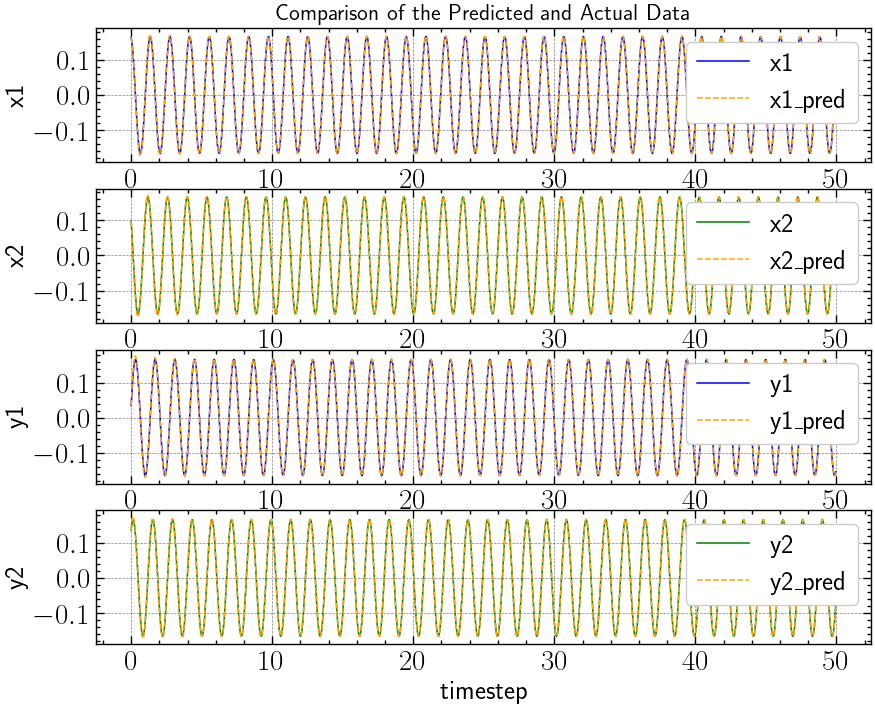

In [90]:
#checking the plots
x1_data = valid_data[:,0]
x2_data = valid_data[:,1]
y1_data = valid_data[:,2]
y2_data = valid_data[:,3]


x1_pred = predicted_data[:,0]
x2_pred = predicted_data[:,1]
y1_pred = predicted_data[:,2]
y2_pred = predicted_data[:,3]

fig, axs = plt.subplots(4, 1, figsize=(10, 8))

timeaxis = np.arange(0, (valid_data.shape[0])*dt, dt)
# Plot data on each subplot

axs[0].plot(timeaxis[:1000], x1_data[:1000], label="x1",color='blue', lw=1.1)
axs[0].plot(timeaxis[:1000], x1_pred[:1000], label="x1_pred", color='orange',linestyle='--', lw=1.1)  
axs[0].set_ylabel("x1")
axs[0].set_title("Comparison of the Predicted and Actual Data")
axs[0].legend(loc='upper right')

axs[1].plot(timeaxis[:1000], x2_data[:1000], label="x2", color='g', lw=1.1)
axs[1].plot(timeaxis[:1000], x2_pred[:1000], label="x2_pred", color='orange',linestyle='--', lw=1.1)  
axs[1].set_ylabel("x2")
axs[1].set_xlabel("timestep")
axs[1].legend(loc='upper right')

axs[2].plot(timeaxis[:1000], y1_data[:1000], label="y1",color='blue', lw=1.1)
axs[2].plot(timeaxis[:1000], y1_pred[:1000], label="y1_pred", color='orange',linestyle='--', lw=1.1)  
axs[2].set_ylabel("y1")

axs[2].legend(loc='upper right')

axs[3].plot(timeaxis[:1000], y2_data[:1000], label="y2", color='g', lw=1.1)
axs[3].plot(timeaxis[:1000], y2_pred[:1000], label="y2_pred", color='orange',linestyle='--', lw=1.1)  
axs[3].set_ylabel("y2")
axs[3].set_xlabel("timestep")
axs[3].legend(loc='upper right')

#fig.tight_layout()
plt.show()


# Map analysis

In [91]:
A, W_in, W_out, W_b = model.get_weights()

#print(W_out)

Lambda = A + np.matmul(W_in, W_out)
Omega =  k_b * W_b


In [92]:
import eigen_analysis as eg

epsilon_list=np.array([3.58,3.65,3.67])
eb = 0
analysis_model = eg.eigenvalues(eb,alpha,Lambda,Omega,dim_reservoir)
eig_array = analysis_model.eigen_values(epsilon_list,int_guess=-0.5)

[ 0.95728775  0.59121648  0.99740473 -0.98873853  0.98426918 -0.71563307
 -0.97630584 -0.95179257  0.82411905 -0.99838774]
[ 0.95998774  0.6000986   0.99772554 -0.98985513  0.98567058 -0.72513132
 -0.97832822 -0.95499647  0.83000147 -0.9985933 ]
[ 0.96073129  0.60263525  0.99780933 -0.99015221  0.98604632 -0.72779126
 -0.97887596 -0.95587709  0.83168037 -0.99864698]


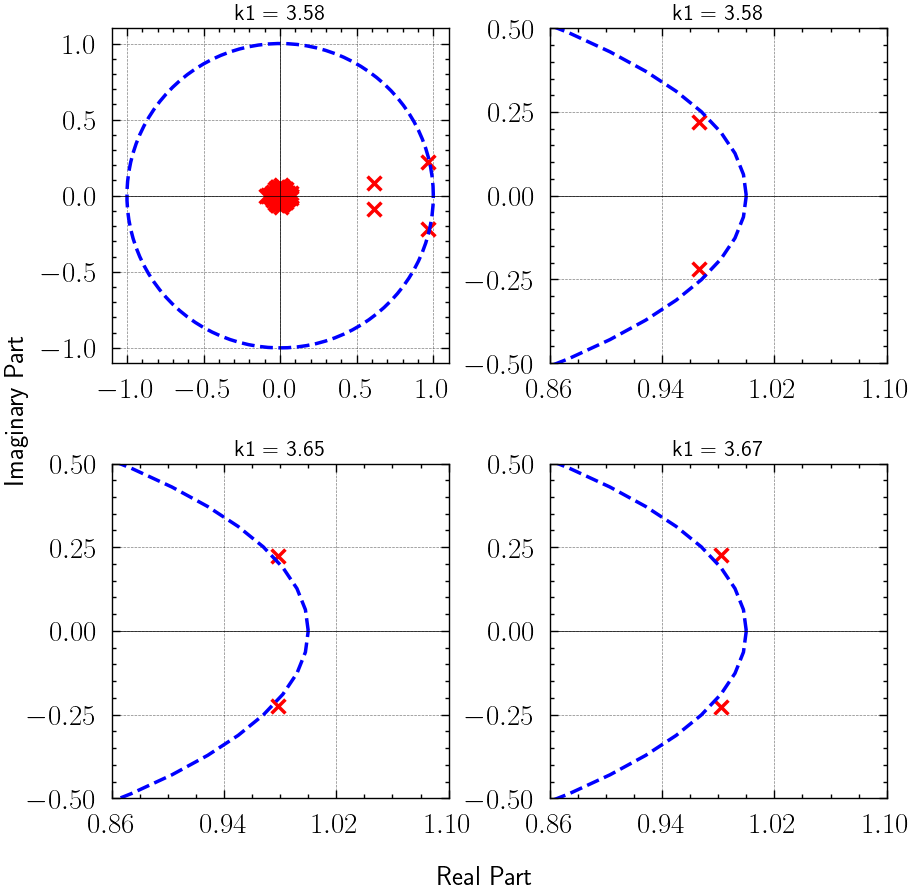

In [93]:
x_lim = [0.86, 1.1, 4]
y_lim = [-0.5,0.5, 5]

analysis_model.Plot_eig_values(eig_array,epsilon_list,x_lim,y_lim)